# Построение модели Prophet для своего ряда

## Импорт модулей

In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
%matplotlib inline

## Данные

In [2]:
paper = pd.read_csv("data/cfe-specialty-writing-papers-mon.csv", index_col="Month", parse_dates=True)
paper = paper.rename(columns={"CFE specialty writing papers monthly sales": "CFE"})

In [3]:
paper.head()

,CFE
Month,
1-01,1359.795
1-02,1278.564
1-03,1508.327
1-04,1419.710
1-05,1440.510


Для более точного прогноза нам следует избавиться от последних трёх записей, так как они не составляют полного периода.

In [4]:
paper = paper[:-3]

В связи с тем, что колонка с месяцем получилось довольной странного формата, её нужно преобразовать в удобный формат.

Допустим, что рассматриваются 2000-е.

In [5]:
def convert_date(date: str):
    year, month = map(int, date.split("-"))
    year += 2000
    return pd.to_datetime("-".join(str(elem) for elem in [year, month]))

In [6]:
paper.index = pd.DatetimeIndex(map(convert_date , paper.index), freq="MS")

In [7]:
paper.head()

,CFE
2001-01-01,1359.795
2001-02-01,1278.564
2001-03-01,1508.327
2001-04-01,1419.710
2001-05-01,1440.510


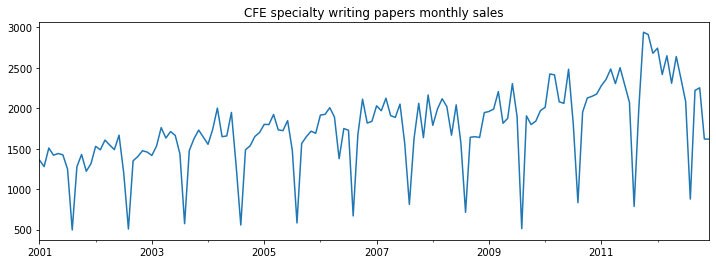

In [8]:
paper["CFE"].plot(figsize=(12,4))
plt.title("CFE specialty writing papers monthly sales")
plt.show()

## Стабилизация дисперсии

Для стабилизации дисперсии выполним преобразование Бокса-Кокса.

Оптимальный параметр преобразования Бокса-Кокса: 1.3756969443665545
Критерий Дики-Фуллера: p=0.5120661918323486


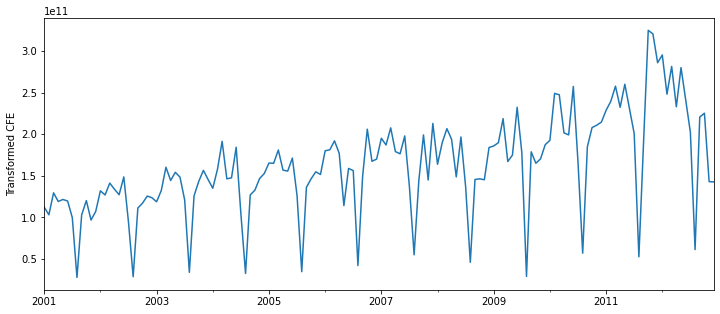

In [9]:
paper["CFE"] *= 100000
paper["CFE_box"], lmbda = boxcox(paper["CFE"])
paper["CFE_box"].plot(figsize=(12,5))
plt.ylabel("Transformed CFE")
print(f"Оптимальный параметр преобразования Бокса-Кокса: {lmbda}")
print(f"Критерий Дики-Фуллера: p={adfuller(paper['CFE_box'])[1]}")

Очевидно наличие сезонности. Сезонность будет учтена во время построения модели SARIMAX, однако для определения порядков авторегресии и скользящего среднего для начала необходимо провести дифференцирование. Из прошлого индивидуального задания было известно, что в данных имеется сезонность каждые 12 месяцев.

## Дифференцирование ряда

Критерий Дики-Фуллера: p=0.007033861686089317


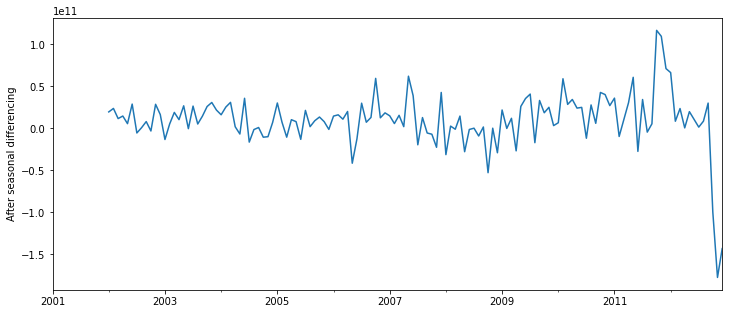

In [10]:
paper["CFE_box_sdiff"] = paper["CFE_box"].diff(12)
paper["CFE_box_sdiff"].plot(figsize=(12,5))
plt.ylabel("After seasonal differencing")
print(f"Критерий Дики-Фуллера: p={adfuller(paper['CFE_box_sdiff'].dropna())[1]}")

Критерий Дики-Фуллера: p=0.6174955445398997


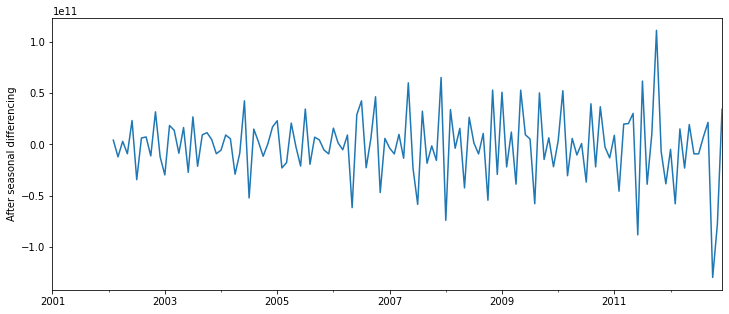

In [11]:
paper["CFE_box_diff"] = paper["CFE_box_sdiff"].diff(1)
paper["CFE_box_diff"].plot(figsize=(12,5))
plt.ylabel("After seasonal differencing")
print(f"Критерий Дики-Фуллера: p={adfuller(paper['CFE_box_diff'].dropna())[1]}")

## Выбор гиперпараметров модели

Для выбора порядка скользящего среднего обратимся к коррелограмме.

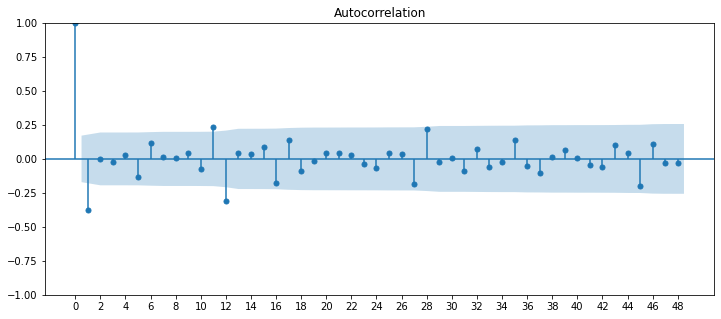

In [12]:
plt.rcParams["figure.figsize"] = (12,5)
plot_acf(paper["CFE_box_diff"].dropna(), lags=48)
plt.xticks(np.arange(0, 50, 2))
plt.show()

Посдедний значимый лаг равен 2. А последний значимый сезонный лаг равен 1 (при лаге 12 автокорреляция значима, при 24 &ndash; незначима). Таким образом, $q_0=2, Q_0=1$.

Для выбора порядка авторегрессии обратимся к частичной автокорреляции.

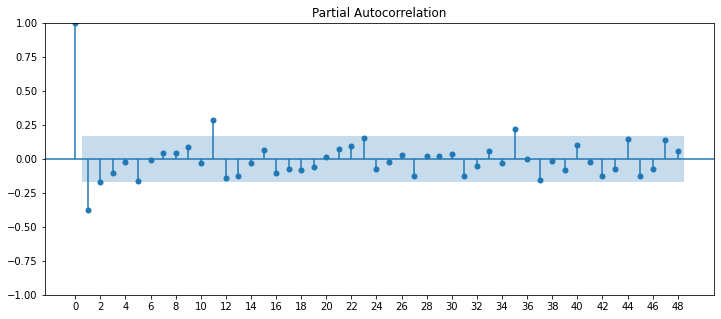

In [13]:
plt.rcParams["figure.figsize"] = (12,5)
plot_pacf(paper["CFE_box_diff"].dropna(), lags=48, method="ywm")
plt.xticks(np.arange(0, 50, 2))
plt.show()

Последний значимый лаг оказался равным 3, значит $p_0=3$. Период сезонности составляет 12. При лаге, равном 12, частичная автокорреляция незначима, значит, $P_0=0$.

Таким образом, будем рассматривать следующие наборы гиперпараметров модели SARIMA:

In [14]:
d=1
D=1
p = range(0, 4)
P = range(0, 2)
q = range(0, 3)
Q = range(0, 2)

In [15]:
parameters = product(p, q, P, Q)
parameters_list = list(parameters)

In [16]:
len(parameters_list)

48

## Mодель statsmodels

In [17]:
paper.index.freq = "MS"

In [18]:
results = []
best_aic = float('inf')

for params in parameters_list:
    try:
        model = SARIMAX(paper["CFE_box"],
                        order=(params[0], d, params[1]), 
                        seasonal_order=(params[2], D, params[3], 12)).fit()
    except ValueError:
        print("Wrong parameters:", param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = params
    results.append([params, model.aic])

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.33262D+01    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   0.000D+00   2.333D+01
  F =   23.326193523504582     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.3

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.32511D+01    |proj g|=  6.65464D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7      9      1     0     0   1.657D-06   2.325D+01
  F =   23.251139928425573     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.32425D+01    |proj g|=  4.73302D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.32005D+01    |proj g|=  3.15149D-02

At iterate    5    f=  2.31991D+01    |proj g|=  3.12284D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      7      1     0     0   3.123D-07   2.320D+01
  F =   23.199129610455895     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.32422D+01    |proj g|=  1.94581D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      4      6      1     0     0   1.090D-06   2.324D+01
  F =   23.241778237110402     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.3

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      4      6      1     0     0   3.701D-05   2.320D+01
  F =   23.196797464547135     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.31728D+01    |proj g|=  6.09519D-02

At iterate    5    f=  2.31631D+01    |proj g|=  2.00186D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.31854D+01    |proj g|=  5.64313D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      7      9      1     0     0   7.071D-05   2.319D+01
  F =   23.185398282386505     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.32419D+01    |proj g|=  2.15126D-02

At iterate    5    f=  2.32414D+01    |proj g|=  7.26175D-07

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.31641D+01    |proj g|=  2.90970D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      7      9      1     0     0   2.690D-06   2.316D+01
  F =   23.164139254942711     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.31987D+01    |proj g|=  2.88826D-02

At iterate    5    f=  2.31955D+01    |proj g|=  2.50230D-03

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.31738D+01    |proj g|=  6.68521D-02

At iterate    5    f=  2.31615D+01    |proj g|=  9.11941D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      7      9      1     0     0   5.001D-05   2.316D+01
  F =   23.161486706064036     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.32411D+01    |proj g|=  5.47977D-03

At iterate   10    f=  2.32403D+01    |proj g|=  1.48393D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     17      1     0     0   4.209D-05   2.324D+01
  F =   23.240242770267773     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.31739D+01    |proj g|=  1.30977D-02

At iterate    5    f=  2.31694D+01    |proj g|=  4.71097D-05

At iter

 This problem is unconstrained.



At iterate   10    f=  2.31994D+01    |proj g|=  6.80274D-04

At iterate   15    f=  2.31994D+01    |proj g|=  7.92747D-03

At iterate   20    f=  2.31991D+01    |proj g|=  2.91838D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     29      1     0     0   2.618D-05   2.320D+01
  F =   23.199086407942016     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.31798D+01    |proj g|=  7.31666D-02

At iter

 This problem is unconstrained.



At iterate   10    f=  2.31663D+01    |proj g|=  2.01325D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     11     13      1     0     0   2.188D-05   2.317D+01
  F =   23.166335281214664     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.32479D+01    |proj g|=  2.06709D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.32073D+01    |proj g|=  3.79451D-02

At iterate    5    f=  2.32054D+01    |proj g|=  2.19202D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      5      7      1     0     0   2.192D-07   2.321D+01
  F =   23.205443291350733     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 v

 This problem is unconstrained.



At iterate    5    f=  2.31729D+01    |proj g|=  4.80176D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     12      1     0     0   1.275D-07   2.317D+01
  F =   23.172851655060370     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.32430D+01    |proj g|=  2.42248D-02

At iterate    5    f=  2.32417D+01    |proj g|=  1.28301D-02

At iterate   10    f=  2.32407D+01    |proj g|=  6.18181D-04

       

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.31674D+01    |proj g|=  2.51412D-02

At iterate    5    f=  2.31645D+01    |proj g|=  1.38393D-02

At iterate   10    f=  2.31640D+01    |proj g|=  8.70415D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     14      1     0     0   8.704D-08   2.316D+01
  F =   23.163956703739029     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate   10    f=  2.31952D+01    |proj g|=  1.03521D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     14      1     0     0   8.172D-06   2.320D+01
  F =   23.195182021283092     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.31730D+01    |proj g|=  6.21395D-02


 This problem is unconstrained.



At iterate    5    f=  2.31628D+01    |proj g|=  1.02242D-02

At iterate   10    f=  2.31614D+01    |proj g|=  4.60135D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     13     17      1     0     0   6.214D-05   2.316D+01
  F =   23.161296171900403     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.33308D+01    |proj g|=  4.07788D-01


/home/egor/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/egor/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.
/home/egor/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/egor/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA param


At iterate    5    f=  2.32411D+01    |proj g|=  3.25060D-02

At iterate   10    f=  2.32401D+01    |proj g|=  2.05525D-03

At iterate   15    f=  2.32395D+01    |proj g|=  9.96080D-03

At iterate   20    f=  2.32392D+01    |proj g|=  3.25695D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     28      1     0     0   2.390D-05   2.324D+01
  F =   23.239243213003348     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  2.31642D+01    |proj g|=  2.08886D-02

At iterate   10    f=  2.31636D+01    |proj g|=  5.12379D-04

At iterate   15    f=  2.31635D+01    |proj g|=  5.21008D-03

At iterate   20    f=  2.31630D+01    |proj g|=  2.12654D-03

At iterate   25    f=  2.31625D+01    |proj g|=  1.24959D-03

At iterate   30    f=  2.31624D+01    |proj g|=  1.13147D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32     35      1     0     0   1.331D-05   2.316D+01
  F =   23.162370330734202     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/egor/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/egor/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.32824D+01    |proj g|=  3.53624D-01

At iterate    5    f=  2.31957D+01    |proj g|=  2.54487D-02

At iterate   10    f=  2.31949D+01    |proj g|=  2.19235D-04

At iterate   15    f=  2.31949D+01    |proj g|=  4.76059D-03

At iterate   20    f=  2.31947D+01    |proj g|=  3.35643D-03

At iterate   25    f=  2.31946D+01    |proj g|=  3.90886D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     34      1     0     0   

/home/egor/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/egor/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   10    f=  2.31609D+01    |proj g|=  5.76500D-04

At iterate   15    f=  2.31606D+01    |proj g|=  8.63908D-03

At iterate   20    f=  2.31602D+01    |proj g|=  4.68562D-03

At iterate   25    f=  2.31599D+01    |proj g|=  2.53023D-03

At iterate   30    f=  2.31599D+01    |proj g|=  8.13074D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     31     34      1     0     0   2.428D-05   2.316D+01
  F =   23.159920322209999     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.31720D+01    |proj g|=  2.22070D-02

At iterate    5    f=  2.31714D+01    |proj g|=  2.16451D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      7      9      1     0     0   1.458D-06   2.317D+01
  F =   23.171397939776607     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 v

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      8     10      1     0     0   1.524D-05   2.317D+01
  F =   23.166822055098653     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.32431D+01    |proj g|=  2.81280D-02

At iterate    5    f=  2.32422D+01    |proj g|=  1.53126D-02


 This problem is unconstrained.



At iterate   10    f=  2.32403D+01    |proj g|=  5.10493D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     15      1     0     0   1.656D-06   2.324D+01
  F =   23.240261970579169     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.31688D+01    |proj g|=  2.10414D-02


 This problem is unconstrained.



At iterate    5    f=  2.31639D+01    |proj g|=  2.10681D-02

At iterate   10    f=  2.31630D+01    |proj g|=  6.48352D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     11     14      1     0     0   1.261D-05   2.316D+01
  F =   23.162985556826818     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.32015D+01    |proj g|=  3.21859D-02


 This problem is unconstrained.



At iterate    5    f=  2.31975D+01    |proj g|=  3.53933D-02

At iterate   10    f=  2.31947D+01    |proj g|=  1.02434D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     12     15      1     0     0   5.309D-06   2.319D+01
  F =   23.194719363940308     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.31754D+01    |proj g|=  6.90704D-02


 This problem is unconstrained.



At iterate    5    f=  2.31614D+01    |proj g|=  8.11771D-03

At iterate   10    f=  2.31603D+01    |proj g|=  1.52821D-03


/home/egor/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/egor/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     13     16      1     0     0   6.549D-06   2.316D+01
  F =   23.160310371807402     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.33324D+01    |proj g|=  4.15100D-01

At iterate    5    f=  2.32409D+01    |proj g|=  1.02568D-02

At iterate   10    f=  2.32398D+01    |proj g|=  2.43252D-03

At iterate   15    f=  2.32391D+01    |proj g|=  8.32540D-03

At iter

/home/egor/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/egor/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.32461D+01    |proj g|=  3.26908D-01

At iterate    5    f=  2.31623D+01    |proj g|=  1.22826D-02

At iterate   10    f=  2.31616D+01    |proj g|=  3.78196D-04

At iterate   15    f=  2.31614D+01    |proj g|=  9.95602D-03

At iterate   20    f=  2.31607D+01    |proj g|=  5.28252D-03

At iterate   25    f=  2.31604D+01    |proj g|=  1.05840D-03

At iterate   30    f=  2.31603D+01    |proj g|=  2.01426D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/home/egor/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/egor/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   10    f=  2.31940D+01    |proj g|=  3.16025D-04

At iterate   15    f=  2.31940D+01    |proj g|=  1.53876D-03

At iterate   20    f=  2.31939D+01    |proj g|=  8.78834D-03

At iterate   25    f=  2.31937D+01    |proj g|=  5.81226D-04

At iterate   30    f=  2.31937D+01    |proj g|=  3.25883D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     30     34      1     0     0   3.259D-05   2.319D+01
  F =   23.193723511012472     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

/home/egor/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/egor/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate    5    f=  2.31608D+01    |proj g|=  2.08373D-02

At iterate   10    f=  2.31587D+01    |proj g|=  1.27797D-03

At iterate   15    f=  2.31585D+01    |proj g|=  5.06689D-03

At iterate   20    f=  2.31578D+01    |proj g|=  2.61815D-03

At iterate   25    f=  2.31576D+01    |proj g|=  2.06258D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     27     32      1     0     0   8.924D-06   2.316D+01
  F =   23.157634784228151     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [19]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by='aic', ascending=True).head())

      parameters          aic
5   (0, 1, 0, 1)  6678.570793
17  (1, 1, 0, 1)  6679.272105
7   (0, 1, 1, 1)  6679.658473
9   (0, 2, 0, 1)  6679.716431
19  (1, 1, 1, 1)  6680.508171


### Визуализация результата

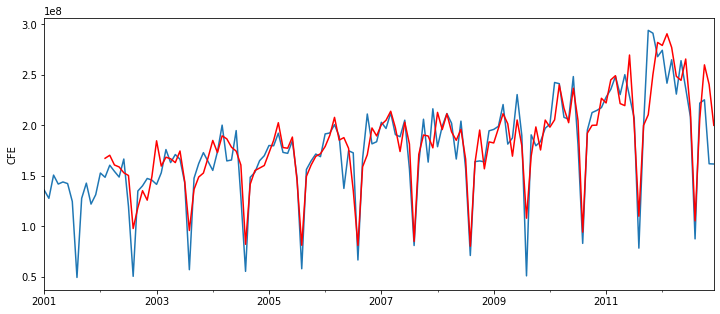

In [20]:
paper["model"] = inv_boxcox(best_model.fittedvalues, lmbda)
paper["CFE"].plot(figsize=(12,5))
paper.model[13:].plot(color='r')
plt.ylabel("CFE")
plt.show()

### Прогноз

In [21]:
start = paper.index[-1] + pd.DateOffset(months=1)
end = start + pd.DateOffset(months=35)

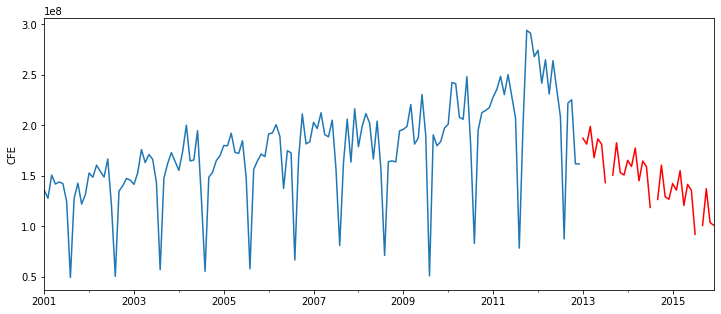

In [22]:
paper["CFE"].plot(figsize=(12,5))
inv_boxcox(best_model.predict(start=start, end=end), lmbda).plot(color='r')
plt.ylabel("CFE")
plt.show()

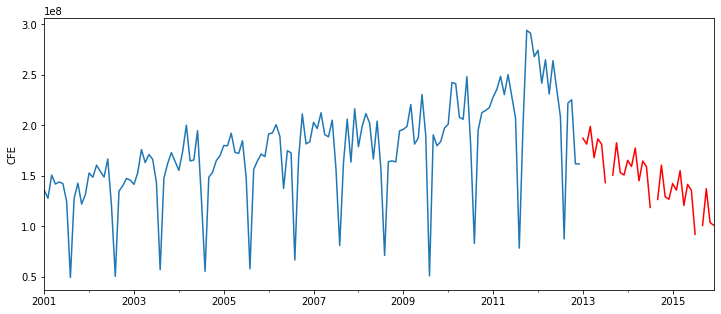

In [23]:
paper["CFE"].plot(figsize=(12,5))
inv_boxcox(best_model.forecast(36), lmbda).plot(color='r')
plt.ylabel("CFE")
plt.show()

По графику видно, что прогноз получился довольно спорным как и в случае первого и второго индивидуального домашнего задания.

## Модель Prophet

### Инициализация и обучение модели

In [25]:
from fbprophet import Prophet

In [26]:
paper.head()

,CFE,CFE_box,CFE_box_sdiff,CFE_box_diff,model
2001-01-01,135979500.0,1.123755e+11,NaN,NaN,1.000000e+00
2001-02-01,127856400.0,1.032454e+11,NaN,NaN,9.326286e+07
2001-03-01,150832700.0,1.296010e+11,NaN,NaN,1.116192e+08
2001-04-01,141971000.0,1.192431e+11,NaN,NaN,1.316461e+08
2001-05-01,144051000.0,1.216531e+11,NaN,NaN,1.367596e+08


In [27]:
paper_prophet = paper[["CFE_box"]]
paper_prophet = paper_prophet.reset_index()
paper_prophet.columns = ["ds", "y"]

In [28]:
paper_prophet.head()

,ds,y
0,2001-01-01,1.123755e+11
1,2001-02-01,1.032454e+11
2,2001-03-01,1.296010e+11
3,2001-04-01,1.192431e+11
4,2001-05-01,1.216531e+11


In [29]:
model = Prophet(weekly_seasonality=False, daily_seasonality=False)
model.add_seasonality(name='yearly', period=365.25, fourier_order=10)
model.fit(paper_prophet)

INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.


Initial log joint probability = -4.78795


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       301.327   9.82109e-06       83.7655      0.9403      0.9403      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       303.728   0.000708351       88.8118           1           1      258   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     293       303.794   4.82019e-09       73.6296      0.2978      0.2978      381   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


### Прогноз

In [30]:
future = model.make_future_dataframe(periods=36, freq="MS")

In [31]:
forecast = model.predict(future)

In [32]:
forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail(12)

,ds,yhat,yhat_lower,yhat_upper
168,2015-01-01,2.631976e+11,2.344852e+11,2.943446e+11
169,2015-02-01,2.695710e+11,2.383749e+11,2.992256e+11
170,2015-03-01,2.885685e+11,2.576718e+11,3.173050e+11
171,2015-04-01,2.676128e+11,2.393001e+11,2.985984e+11
172,2015-05-01,2.671231e+11,2.350522e+11,2.966006e+11
173,2015-06-01,2.807230e+11,2.502419e+11,3.125182e+11
174,2015-07-01,2.342407e+11,2.043360e+11,2.660355e+11
175,2015-08-01,1.288484e+11,9.852012e+10,1.571845e+11
176,2015-09-01,2.310563e+11,2.006060e+11,2.610858e+11
177,2015-10-01,2.743987e+11,2.445936e+11,3.075064e+11


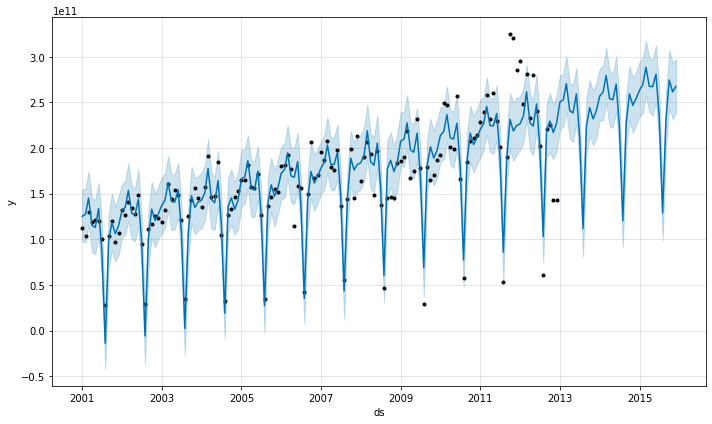

In [33]:
model.plot(forecast)
plt.show()

На графике видно, что прогноз полученный через `Prophet` **гораздо** лучше чем прогноз полученный через `statsmodels`.

Выводы:

`Prophet` 👍

`statsmodels` 👎

## Сравнение Prophet и statsmodels

In [34]:
from statsmodels.tools.eval_measures import mse

### MSE полученное при построении модели в Prophet

In [35]:
mse_prophet = mse(paper["CFE"], forecast.loc[:, "yhat"][:-36])
print(mse_prophet)

2.905175917770373e+22


### MSE полученное при построении модели в statsmodels

In [36]:
mse_statsmodels = mse(paper["CFE"], paper["model"])
print(mse_statsmodels)

651229283362641.2


In [37]:
mse_prophet > mse_statsmodels

True

Получилось, что MSE модели `Prophet` больше, чем MSE модели `statsmodels`, но если рассматривать прогноз, который мы получили, то лучший прогноз дала модель `Prophet`.